# Comparison of different sampling approaches

This notebook enables comparison of different sampling approaches for estimating pole position in the presence of secular variation of the geomagnetic field and within site scatter. You can use this notebook to make a comparison similar to that shown below from Figure 3s of Sapienza et al. (2023) while providing your own parameters.

<table style="border-collapse: collapse; border: none;">
    <tr>
        <td style="border: none;"><img src="https://raw.githubusercontent.com/PolarWandering/PaleoSampling/57e98e6cc79638b28949893508981cbfcc3a1643/figures/figure3_histogram/Figure3a.png" width="500"></td>
        <td style="border: none; vertical-align: bottom; width: 300px;">
            <b>Figure 3a:</b> Comparison between two different sampling strategies to determine a mean paleomagnetic pole position in the presence of outliers for a fixed number of total samples (n = 100). The red histograms and curve are strategy 1 where we have one sample per site (n0 = 1), one hundred sites (N = 100) and we use the Vandamme filter. The blue histograms and curve are strategy 2 where n0 = 5, (N = 20) and we filter all the outliers (perfect detection algorithm) for (a) p_outlier = 0.10.
        </td>
    </tr>
</table>

These tools can help guide decisions about the tradeoffs between the number of site ($N$) and the number of samples per site ($n_0$) while evaluating or designing a study.

## Import Python packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pmagpy.pmag as pmag
import pmagpy.ipmag as ipmag

import smpsite as smp

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline

## Define parameters

The data generation model requires that the following parameters are given:
- `site_lat` is the latitude of the study site (between 0 and 90º)
- `outlier_rate` which is the fraction of samples that are spurious (between 0.0 [0% outliers] and 1.0 [100% outliers])
- `kappa_within_site` Fisher precision parameter ($\kappa$) for the samples within a site
- `secular_method` is the method used to estimate secular variation with the options being `"G"` (model G), `"tk03"` (TK03), or `"Fisher"` (Fisher distribution). If `"Fisher"` is chosen, a `kappa_secular` needs to be defined which is the Fisher precision parameter associated with secular variation
- `N` number of sites
- `n0` number of samples per site

### Enter parameters that are the same in both sampling strategies 

`latitude`, `outlier_rate`, `kappa_within_site`, and `secular_method` make sense to define across both sampling strategies that are being compared. Let's define them in the cell below (**you can change these values to match those that are the best estimates for your study**):

In [2]:
# enter the values for the scenario you are exploring
site_lat = 30
site_long = 0
outlier_rate = 0.10
kappa_within_site = 60
secular_method = "G"

### Enter sites and samples per site for approach 1

Now we can set how many sites and samples per sites for approach 1 (say 100 sites with 1 sample each for a total of 100 samples):

In [3]:
# enter the number of sites for approach 1
N_approach1 = 100 
# enter the number of samples per site for approach 1
n0_approach1 = 1

### Enter sites and samples per site for approach 2

Now we can set how many sites and samples per sites for approach 2 (say 20 sites with 5 samples each for a total of 100 samples):

In [4]:
# enter the number of sites for approach 2
N_approach2 = 20 
# enter the number of samples per site for approach 2
n0_approach2 = 5

## Assign parameters for each approach

We will create a parameters object that has these values assigned for approach 1 (`params1`) and for approach 2 (`params2`). Nothing needs to be changed in the code cell below as it will take the values that are defined above.

In [5]:
params1 = smp.Params(N=N_approach1,
                     n0=n0_approach1,
                     kappa_within_site=kappa_within_site,
                     site_lat=site_lat, 
                     site_long=site_long,
                     outlier_rate=outlier_rate,
                     secular_method=secular_method,
                     kappa_secular=None)

params2 = smp.Params(N=N_approach2,
                     n0=n0_approach2,
                     kappa_within_site=kappa_within_site,
                     site_lat=site_lat, 
                     site_long=site_long,
                     outlier_rate=outlier_rate,
                     secular_method=secular_method,
                     kappa_secular=None)

## Generate the simulations with the chosen parameters

### Chose the outlier detection strategy

There are three options for outlier detection:
- `"True"` This choice corresponds to perfect outlier detection. Recall that the outliers are generated at the sample level. One can envision that with 6 samples per site and a 10% outlier rate that it would be straight forward to be able to filter out outliers by looking for site level consistency.
- `"False"` This choice corresponds to no outlier detection. All samples are used regardless of their position in calculating the site level means without filtering.
- `"vandamme"` This choice corresponds to using the Vandamme (1994) filter to detect outlier directions. This approach provides a quantitative way to filter outliers for a 1 sample per site sampling strategy

We need to assign an outlier detection strategy for approach 1 and approach 2. In the versions of these approaches given above where approach 1 is 50 sites with 1 sample per site and approach 2 is 10 sites with 5 samples per site, the approach could be taken of using the `vandamme` method for approach 1 and the `True` perfect outlier detection method for approach 2.

In [6]:
#assign "True" or "False" or "vandamme" for approach 1
approach1_outlier_method = "vandamme"

#assign "True" or "False" or "vandamme" for approach 2
approach2_outlier_method = "True"

### Chose number of iterations
Before the simulations are run, the number of times the poles are simulated needs to be specified with the `n_iters` variable. Something like 1000 should do a decent job showing the resulting distribution. We used `n_iters = 1000` in Sapienza et al. 2023.

In [7]:
#change the number of iterations if you want
n_iters = 1000

### Run the simulations

The simulations take a while to run (and will take longer for large values of `n_inters`)

In [8]:
%%time

approach_1_estimates = smp.simulate_estimations(params1, n_iters=n_iters, ignore_outliers=approach1_outlier_method)
approach_2_estimates = smp.simulate_estimations(params2, n_iters=n_iters, ignore_outliers=approach2_outlier_method)

CPU times: user 1min 32s, sys: 336 ms, total: 1min 33s
Wall time: 1min 33s


## Assess the simulated results

### Calculate RMSE
The root mean square error of all of the simulations combined can be calculated for a given approach.

In [9]:
approach_1_rmse = np.mean(approach_1_estimates.error_angle**2)**.5
approach_2_rmse = np.mean(approach_2_estimates.error_angle**2)**.5

print('The RMSE for approach 1 is: ', round(approach_1_rmse,1),'º')
print('The RMSE for approach 2 is: ', round(approach_2_rmse,1),'º')

The RMSE for approach 1 is:  1.9 º
The RMSE for approach 2 is:  3.4 º


### Calculate error angle percentile

Rather than assessing the mean error, it could be informative to investigate the percentile of the resulting error angles. Calculating the 95 percentile assesses what the error angle is that 95% of the simulations are for the parameters of a given scenario.

In [10]:
approach_1_95_percentile = np.percentile(approach_1_estimates.error_angle,95)
approach_2_95_percentile = np.percentile(approach_2_estimates.error_angle,95)

print('The 95 percentile error angle for approach 1 is: ', round(approach_1_95_percentile,1),'º')
print('The 95 percentile error angle for approach 2 is: ', round(approach_2_95_percentile,1),'º')

The 95 percentile error angle for approach 1 is:  3.3 º
The 95 percentile error angle for approach 2 is:  6.1 º


### Plot distribution of error angles

The distribution of the error angles from the two approaches can be plotted. First, let's extract the parameters associated with each approach to plot on the figure.

In [11]:
def annotation_text(approach_name, params, outlier_method):
    """
    Generate annotation text based on provided parameters and outlier detection method.
    
    Args:
        approach_name (str): The name of the approach (e.g. "Approach 1").
        params (object): An object containing attributes related to simulation parameters.
        outlier_method (str): The name of the outlier detection method ("vandamme", "True", or "False").
        
    Returns:
        str: A formatted annotation string containing simulation parameters and outlier method.
    """
    if outlier_method == "vandamme":
        outlier_method = "Vandamme"
    elif outlier_method == "True":
        outlier_method = "perfect"
    elif outlier_method == "False":
        outlier_method = "none"
    
    # Display the specified params1 attributes in the annotation box
    annotation_text = (f'{approach_name}:\n'
                    f'number of sites = {params.N}\n'
                    f'samples per site = {params.n0}\n'
                    f'within site kappa = {params.kappa_within_site}\n'
                    f'site latitude = {params.site_lat}º\n'
                    f'outlier rate = {params.outlier_rate}\n'
                    f'secular variation model = {params.secular_method}\n'
                    f'outlier detection = {outlier_method}')
    return annotation_text

annotation_text_approach1 = annotation_text('Approach 1', params1, approach1_outlier_method)
annotation_text_approach2 = annotation_text('Approach 2', params2, approach2_outlier_method)

Now we can make the plot showing histograms of the error angle for each approach.

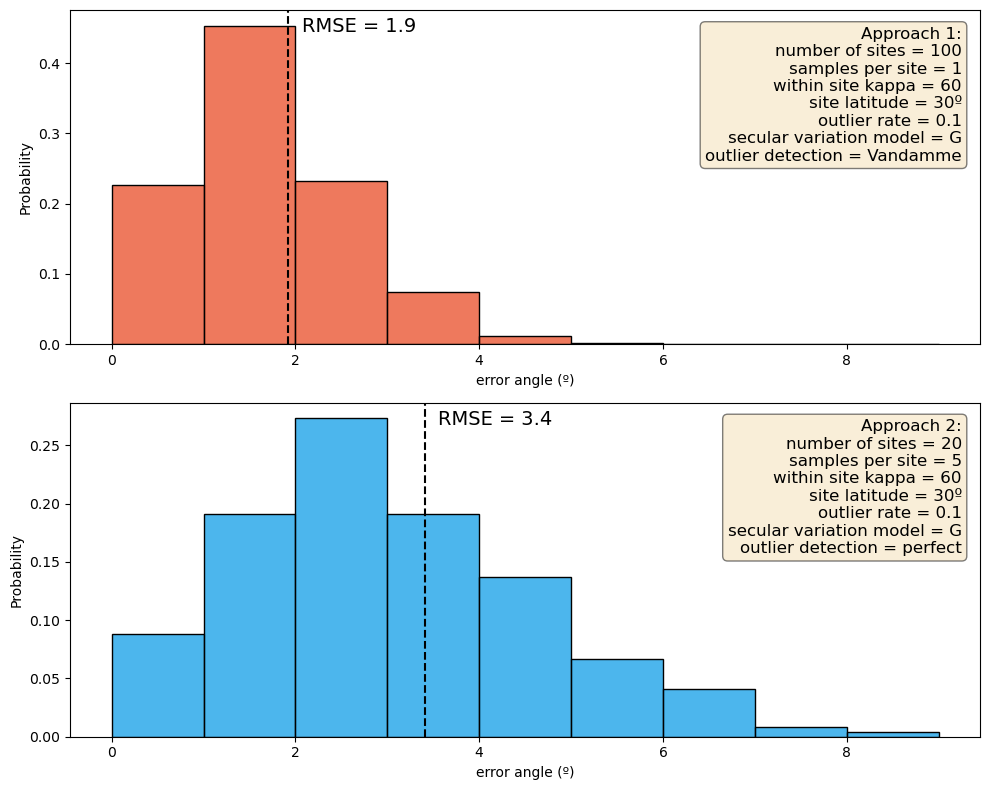

In [12]:
# Calculate the 99.9 percentile for each approach to set axes x scale
percentile_1 = np.percentile(approach_1_estimates.error_angle, 99.9)
percentile_2 = np.percentile(approach_2_estimates.error_angle, 99.9)

# Find the maximum value between the two percentiles and round up to nearest integer
max_x_value = np.ceil(max(percentile_1, percentile_2))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
sns.histplot(approach_1_estimates.error_angle, ax=axes[0], color='#e84118', 
             stat='probability', binwidth=1, binrange=(0, max_x_value), alpha=.7)
sns.histplot(approach_2_estimates.error_angle, ax=axes[1], color='#0097e6', 
             stat='probability', binwidth=1, binrange=(0, max_x_value), alpha=.7)

for ax in axes:
    ax.set_xlabel("error angle (º)")

for ax, rmse in zip(axes, [approach_1_rmse, approach_2_rmse]):
    ax.axvline(rmse, color='black', linestyle='--')
    ax.annotate(f'RMSE = {rmse:.1f}', (rmse, ax.get_ylim()[1]*0.95), xytext=(10,0), textcoords='offset points', 
                verticalalignment='center', fontsize=14)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axes[0].text(0.98, 0.95, annotation_text_approach1, 
             transform=axes[0].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=props) 
axes[1].text(0.98, 0.95, annotation_text_approach2, 
             transform=axes[1].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()